In [1]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from matplotlib_venn import venn2
from matplotlib_venn import venn3
#from lineage import get_lineage_coll, get_lineage_snp
#from resistance import get_resistance_snp

In [2]:
def import_VCF42_to_pandas(vcf_file, sep='\t'):
    header_lines = 0
    with open(vcf_file) as f:
        first_line = f.readline().strip()
        next_line = f.readline().strip()
        while next_line.startswith("##"):
            header_lines = header_lines + 1
            #print(next_line)
            next_line = f.readline()
    
    if first_line.startswith('#CHROM'):
        
        #Use first line as header
        dataframe = pd.read_csv(vcf_file, sep=sep, header=0)
        sample = dataframe.columns[-1]
        dataframe.rename(columns={sample:'sample'}, inplace=True)
        
        for index in dataframe.index:
            info_fields = re.findall(r';*([a-zA-Z]{1,20})=', dataframe.loc[index,'INFO'])
            info_values = re.findall(r'-?\d+\.?\d*e?[+-]?\d{0,2}', dataframe.loc[index,'INFO'])
            
            format_fields = dataframe.loc[index,'FORMAT'].split(":")
            format_values = dataframe.loc[index,'sample'].split(":")
                                    
            for ifield, ivalue in zip(info_fields,info_values):
                dataframe.loc[index,ifield] = ivalue
                
            for ffield, fvalue in zip(format_fields,format_values):
                dataframe.loc[index,ffield] = fvalue
            #if len(format_values[1].split(",")) != 2:
            #    print(format_values[1].split(","), index)
            #    print(dataframe.iloc[index])
        dataframe.rename(columns={'AF':'af'}, inplace=True)
        dataframe['REF_AD'] = dataframe['AD'].str.split(",").str[-2:].str[0]
        dataframe['ALT_AD'] = dataframe['AD'].str.split(",").str[-2:].str[1]
        
        to_float = ['QUAL', 'AC', 'af', 'AN', 'BaseQRankSum', 'DP', 'ExcessHet', 'FS',
       'MLEAC', 'MLEAF', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR','GQ','ALT_AD', 'REF_AD']
        
        to_int = ['POS']
        
        for column in dataframe.columns:
            if column in to_float:
                dataframe[column] = dataframe[column].astype(float)
                
        for column in dataframe.columns:
            if column in to_int:
                dataframe[column] = dataframe[column].astype(int)
        
        dataframe['aF'] = dataframe['REF_AD']/dataframe['DP']
        dataframe['AF'] = dataframe['ALT_AD']/dataframe['DP']

                
    else:
        print("This vcf file is not v4.2")
        sys.exit(1)
           
    return dataframe

In [3]:
sample_list = []
vcf_files = []

for file in os.listdir("./"):
    if file.endswith("vcf"):
        name = file.split(".")[0]
        sample_list.append(name)
        vcf_files.append(file)
        
sample_list.sort()
vcf_files.sort()

print(sample_list)
print(vcf_files)


['1_vcf_btm', '1_vcf_top', '2_vcf_btm', '2_vcf_top', '3_vcf_btm', '3_vcf_top', '4_vcf_btm', '4_vcf_top', '5_vcf_btm', '5_vcf_top', '6_vcf_btm', '6_vcf_top']
['1_vcf_btm.vcf', '1_vcf_top.vcf', '2_vcf_btm.vcf', '2_vcf_top.vcf', '3_vcf_btm.vcf', '3_vcf_top.vcf', '4_vcf_btm.vcf', '4_vcf_top.vcf', '5_vcf_btm.vcf', '5_vcf_top.vcf', '6_vcf_btm.vcf', '6_vcf_top.vcf']


In [10]:
dict_vcf = {}
for vcf, df_name in zip(vcf_files, sample_list):
    dict_vcf[df_name] = import_VCF42_to_pandas(vcf)

This vcf file is not v4.2


SystemExit: 1

In [12]:
dict_vcf["3_vcf_top"].head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,...,AD,GQ,PL,PGT,PID,PS,REF_AD,ALT_AD,aF,AF
0,MTB_anc,237,.,G,A,3228.6,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-9.720e-01;DP=...,GT:AD:DP:GQ:PL,"0/1:22,111:133:99:3236,0,383",...,"22,111",99.0,"3236,0,383",NaN,NaN,NaN,22.0,111.0,0.165414,0.834586
1,MTB_anc,4191,.,A,G,2379.6,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=0.114;DP=105;E...,GT:AD:DP:GQ:PL,"0/1:21,84:105:99:2387,0,349",...,"21,84",99.0,"2387,0,349",NaN,NaN,NaN,21.0,84.0,0.200000,0.800000
2,MTB_anc,5075,.,C,T,3620.6,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-1.065e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:32,126:158:99:3628,0,615",...,"32,126",99.0,"3628,0,615",NaN,NaN,NaN,32.0,126.0,0.202532,0.797468
3,MTB_anc,6112,.,G,C,2643.6,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-5.340e-01;DP=...,GT:AD:DP:GQ:PL,"0/1:13,102:115:56:2651,0,56",...,"13,102",56.0,"2651,0,56",NaN,NaN,NaN,13.0,102.0,0.113043,0.886957
4,MTB_anc,8452,.,C,T,3262.6,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-4.150e-01;DP=...,GT:AD:DP:GQ:PL,"0/1:32,114:146:99:3270,0,630",...,"32,114",99.0,"3270,0,630",NaN,NaN,NaN,32.0,114.0,0.219178,0.780822


In [13]:
def scatter_vcf_pos_vcf_test(vcf_df, name):
    filter_homoz_top = 0.96
    filter_homoz_bottom = (1 - filter_homoz_top)
    
    y = vcf_df['AF']
    x = vcf_df['POS']
    plt.figure(figsize=(50,15))
    plt.margins(x=0.01, y=0.01, tight=True)
    
    mean = vcf_df['AF'][(vcf_df['AF'] < filter_homoz_top) & (vcf_df['AF'] > filter_homoz_bottom)].mean(axis = 0)
    
    #col_mean = np.where(vcf_df['AF'][(vcf_df['AF'] < filter_homoz_top) & (vcf_df['AF'] > filter_homoz_bottom)] > mean,'c','salmon')
    col_mean = 'c'
    label_fontsize = 30
    tick_fontsize = 20
    plt.ylabel('Allele Frequency', fontsize=label_fontsize)
    plt.xlabel('Genome Position', fontsize=label_fontsize)
    plt.title(name, fontsize=label_fontsize)
    
    plt.ylim(0, 1)
    
    plt.yticks(fontsize=tick_fontsize)
    plt.xticks(fontsize=tick_fontsize) #rotation=90
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()
    
    """
    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='1', color='k')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='1', color='k')
    
    # Turn on/off the display of all ticks.
    plt.tick_params(which='minor', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='on') # turn on bottom ticks
    """
    plt.grid(True)
    
    plt.scatter(x, y, color=col_mean, alpha=0.8, s=50)
    
    plt.show()

# Draw Scatter
-----------------------

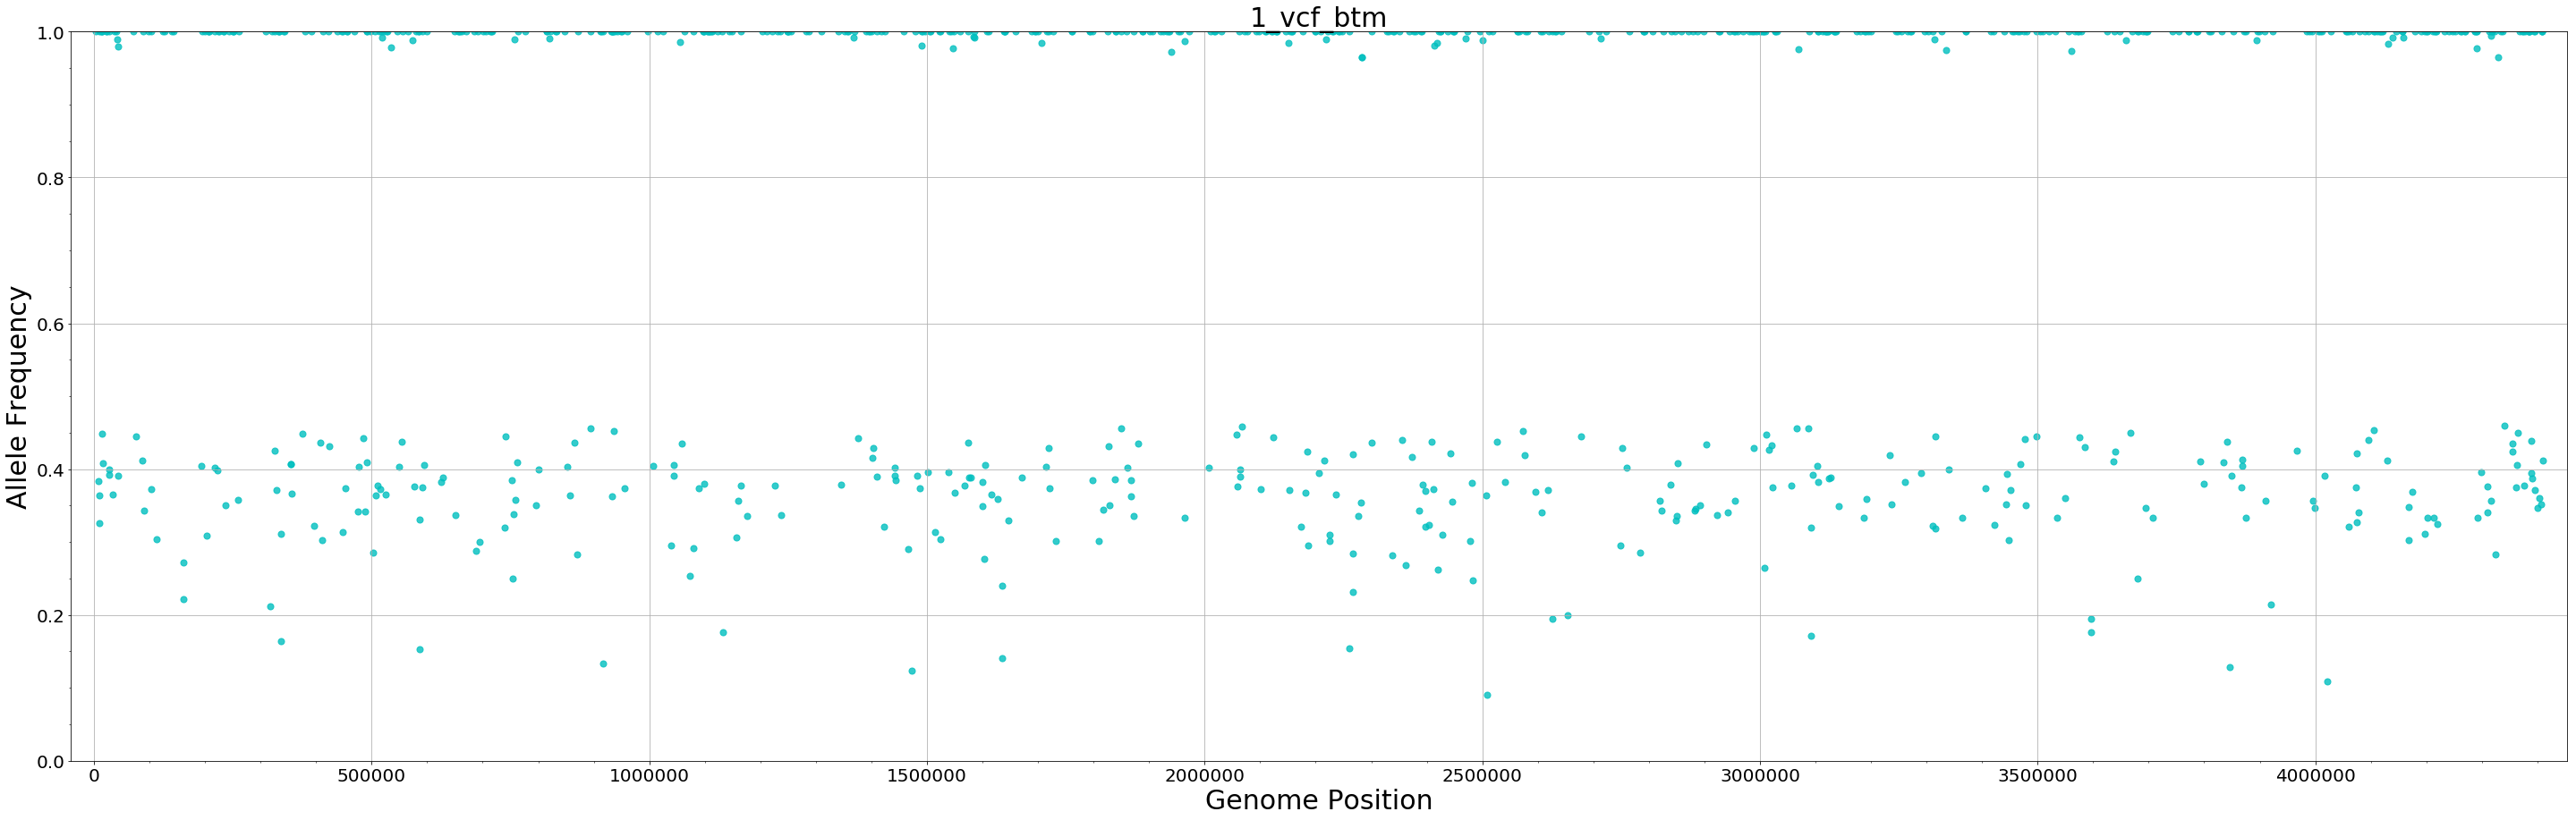

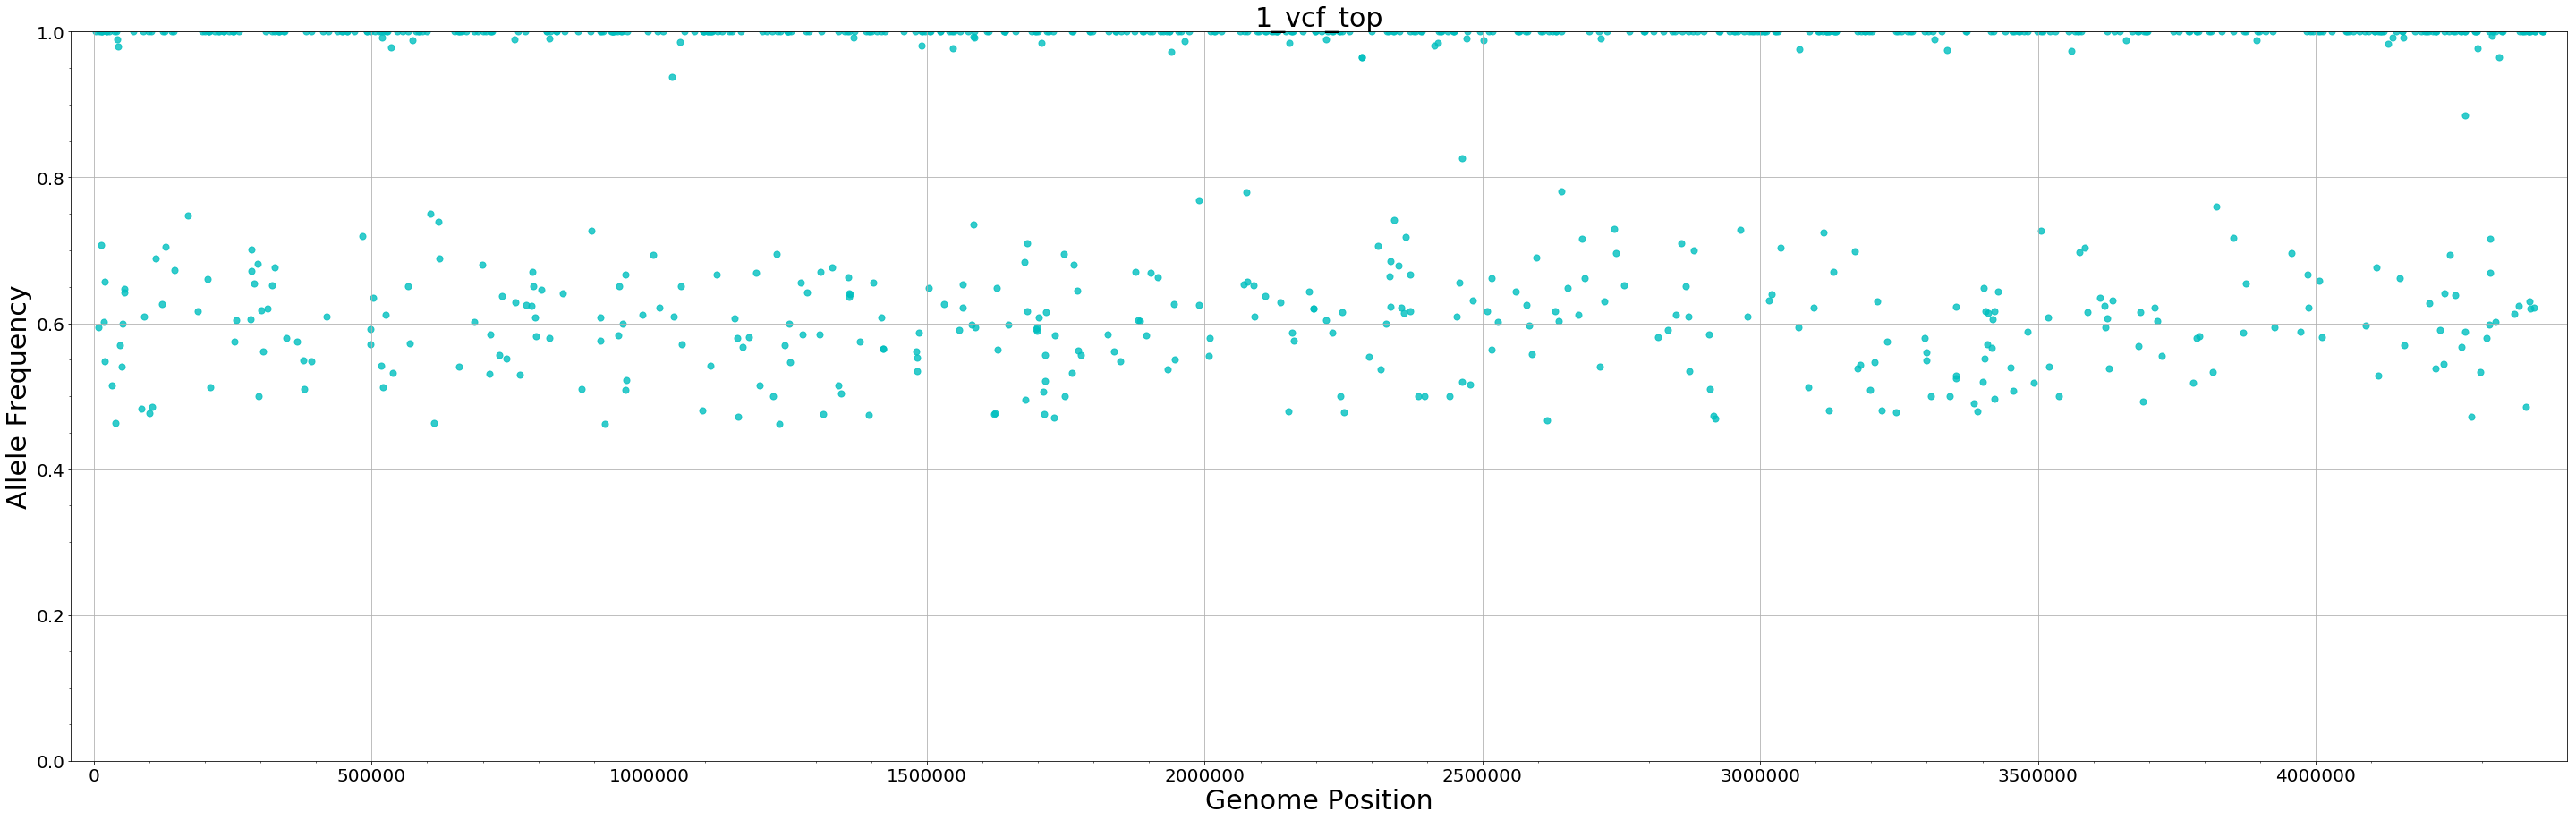

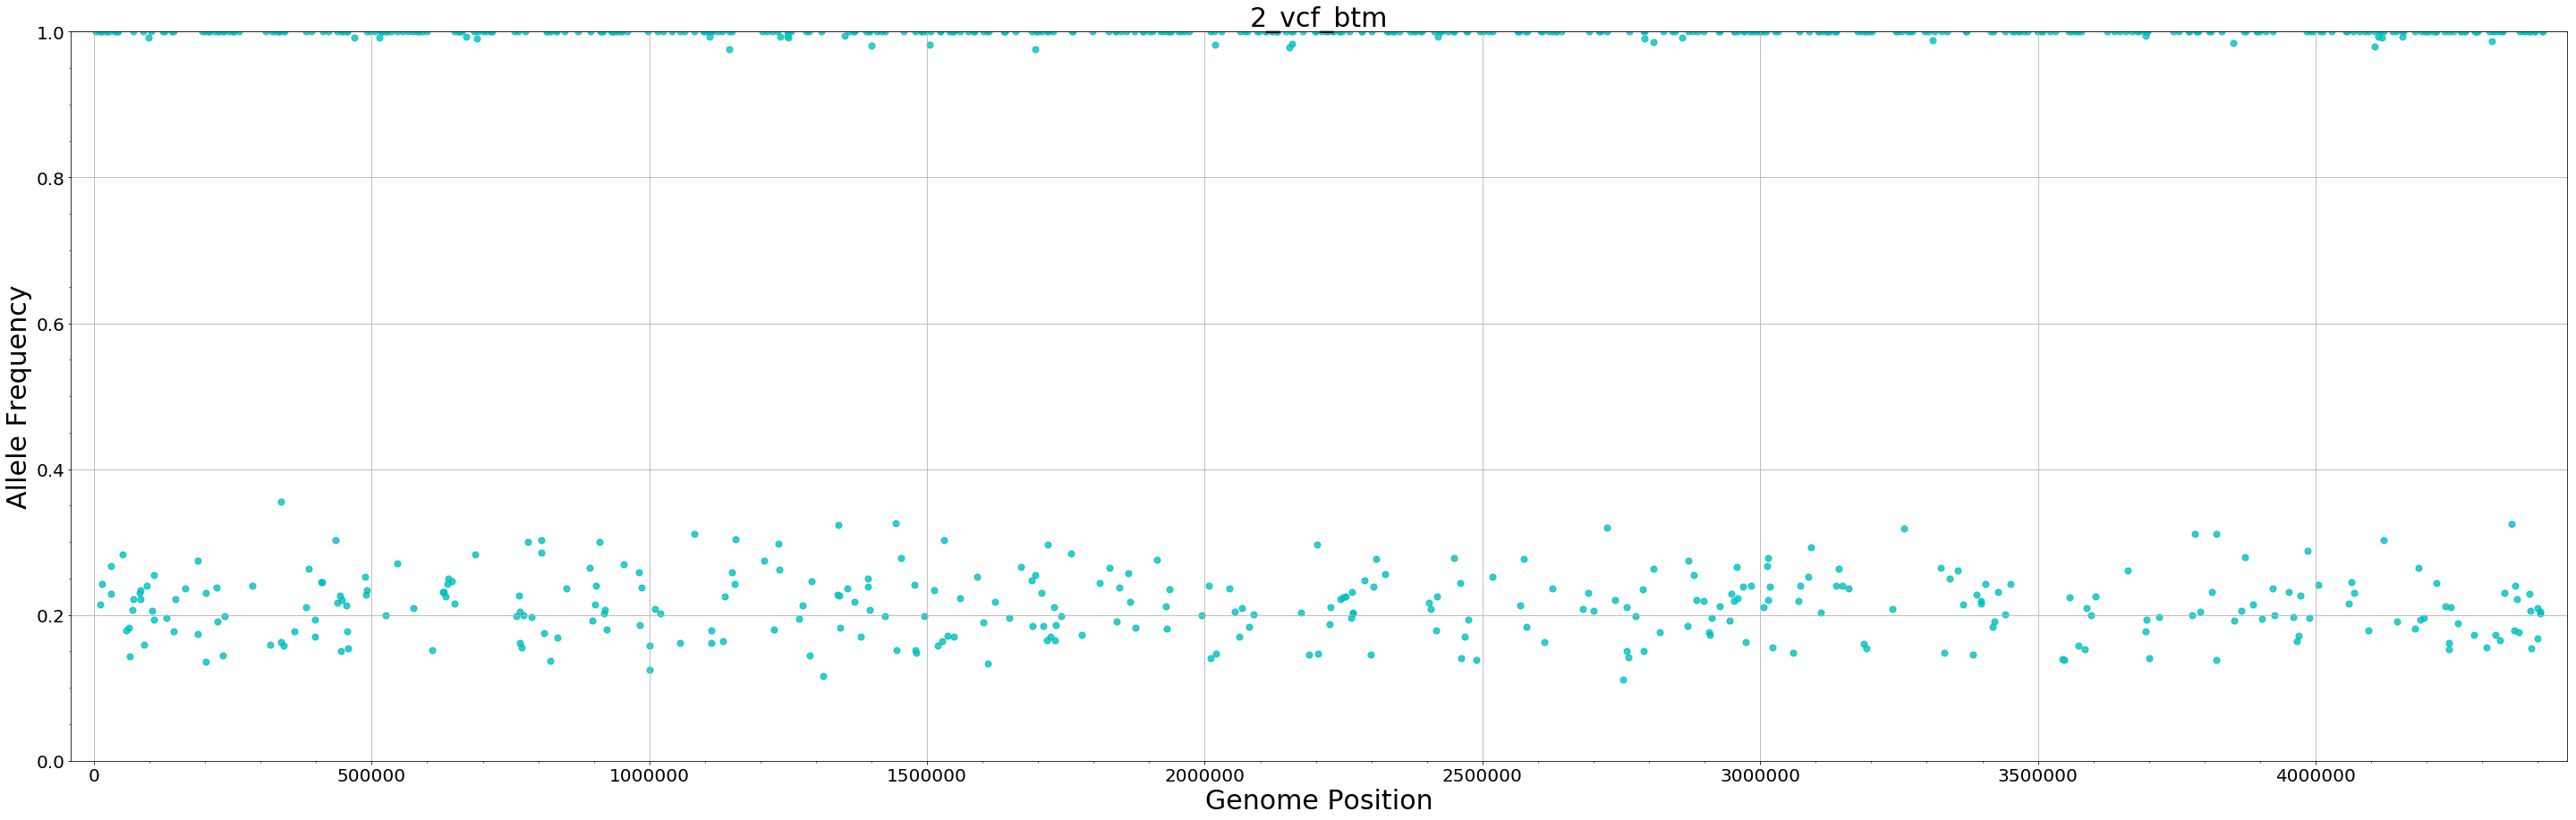

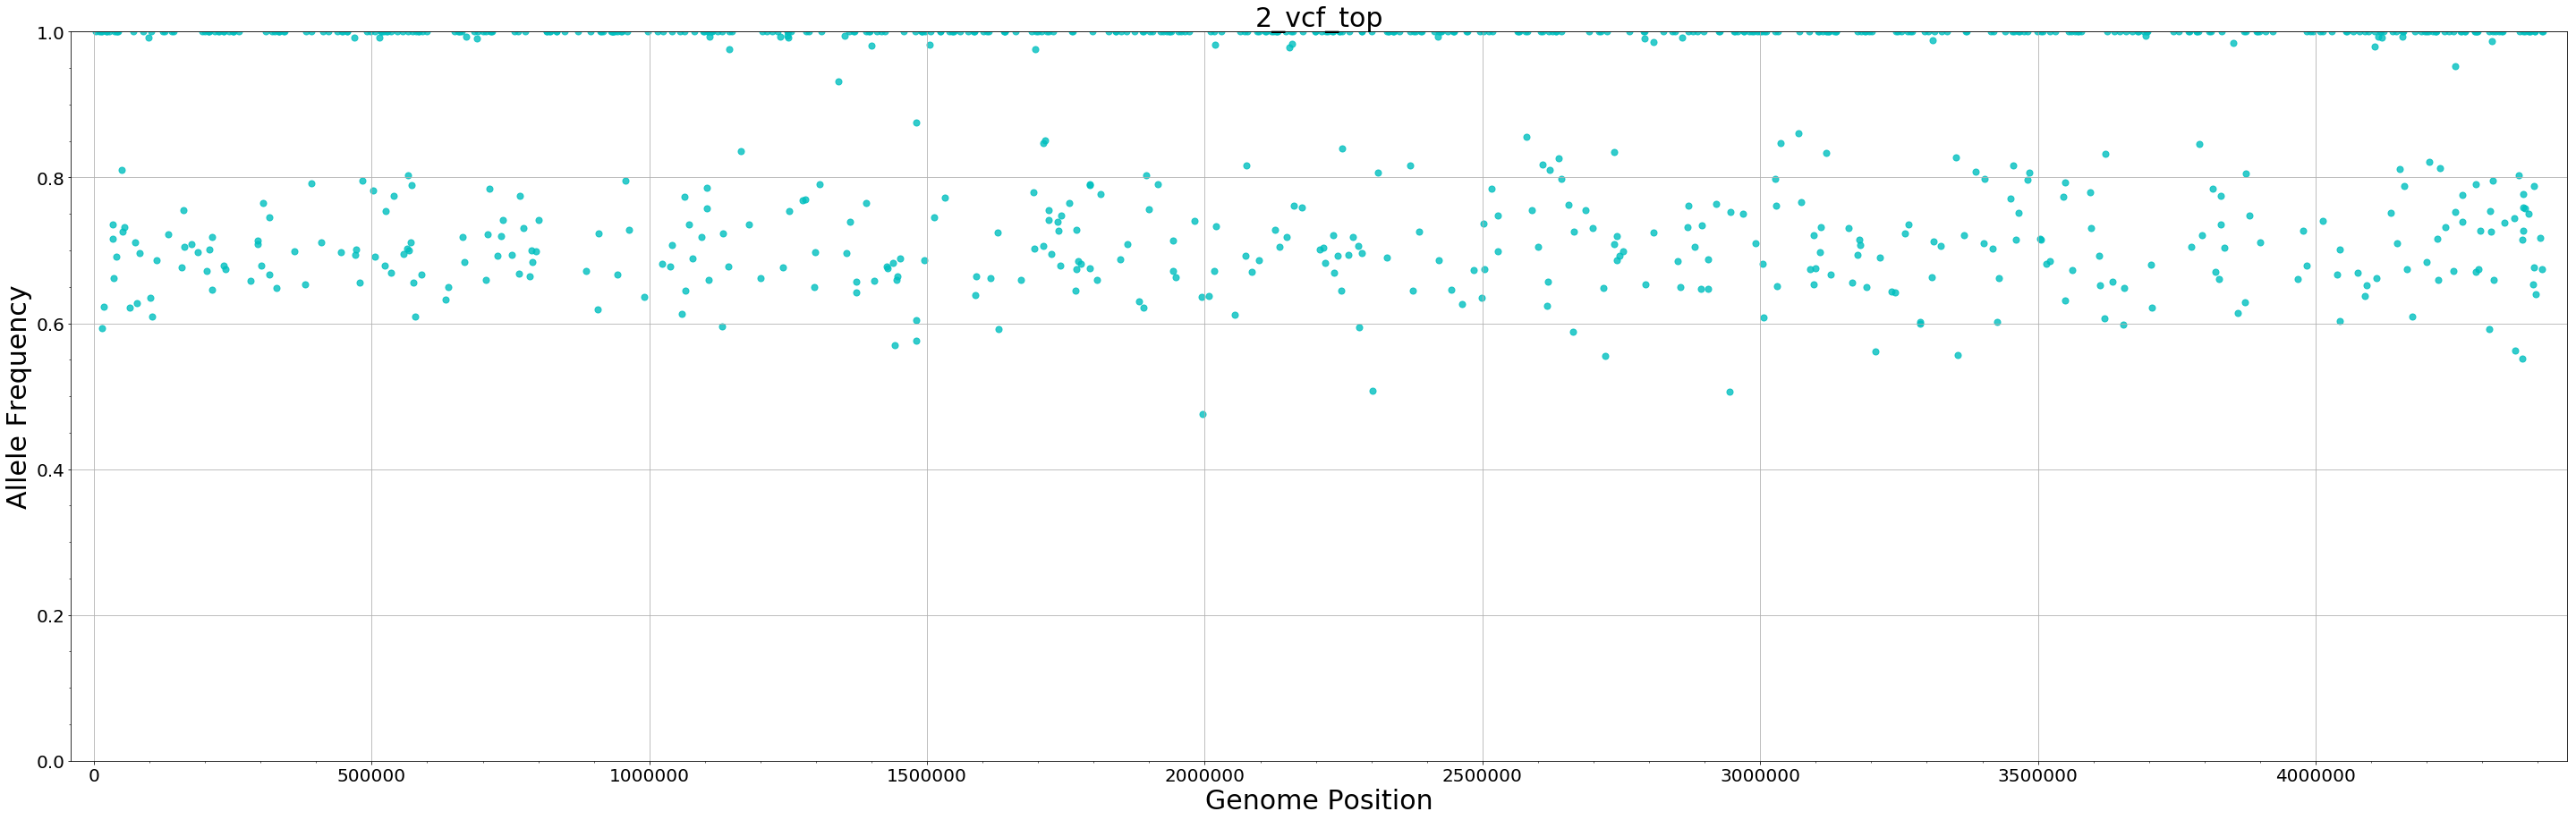

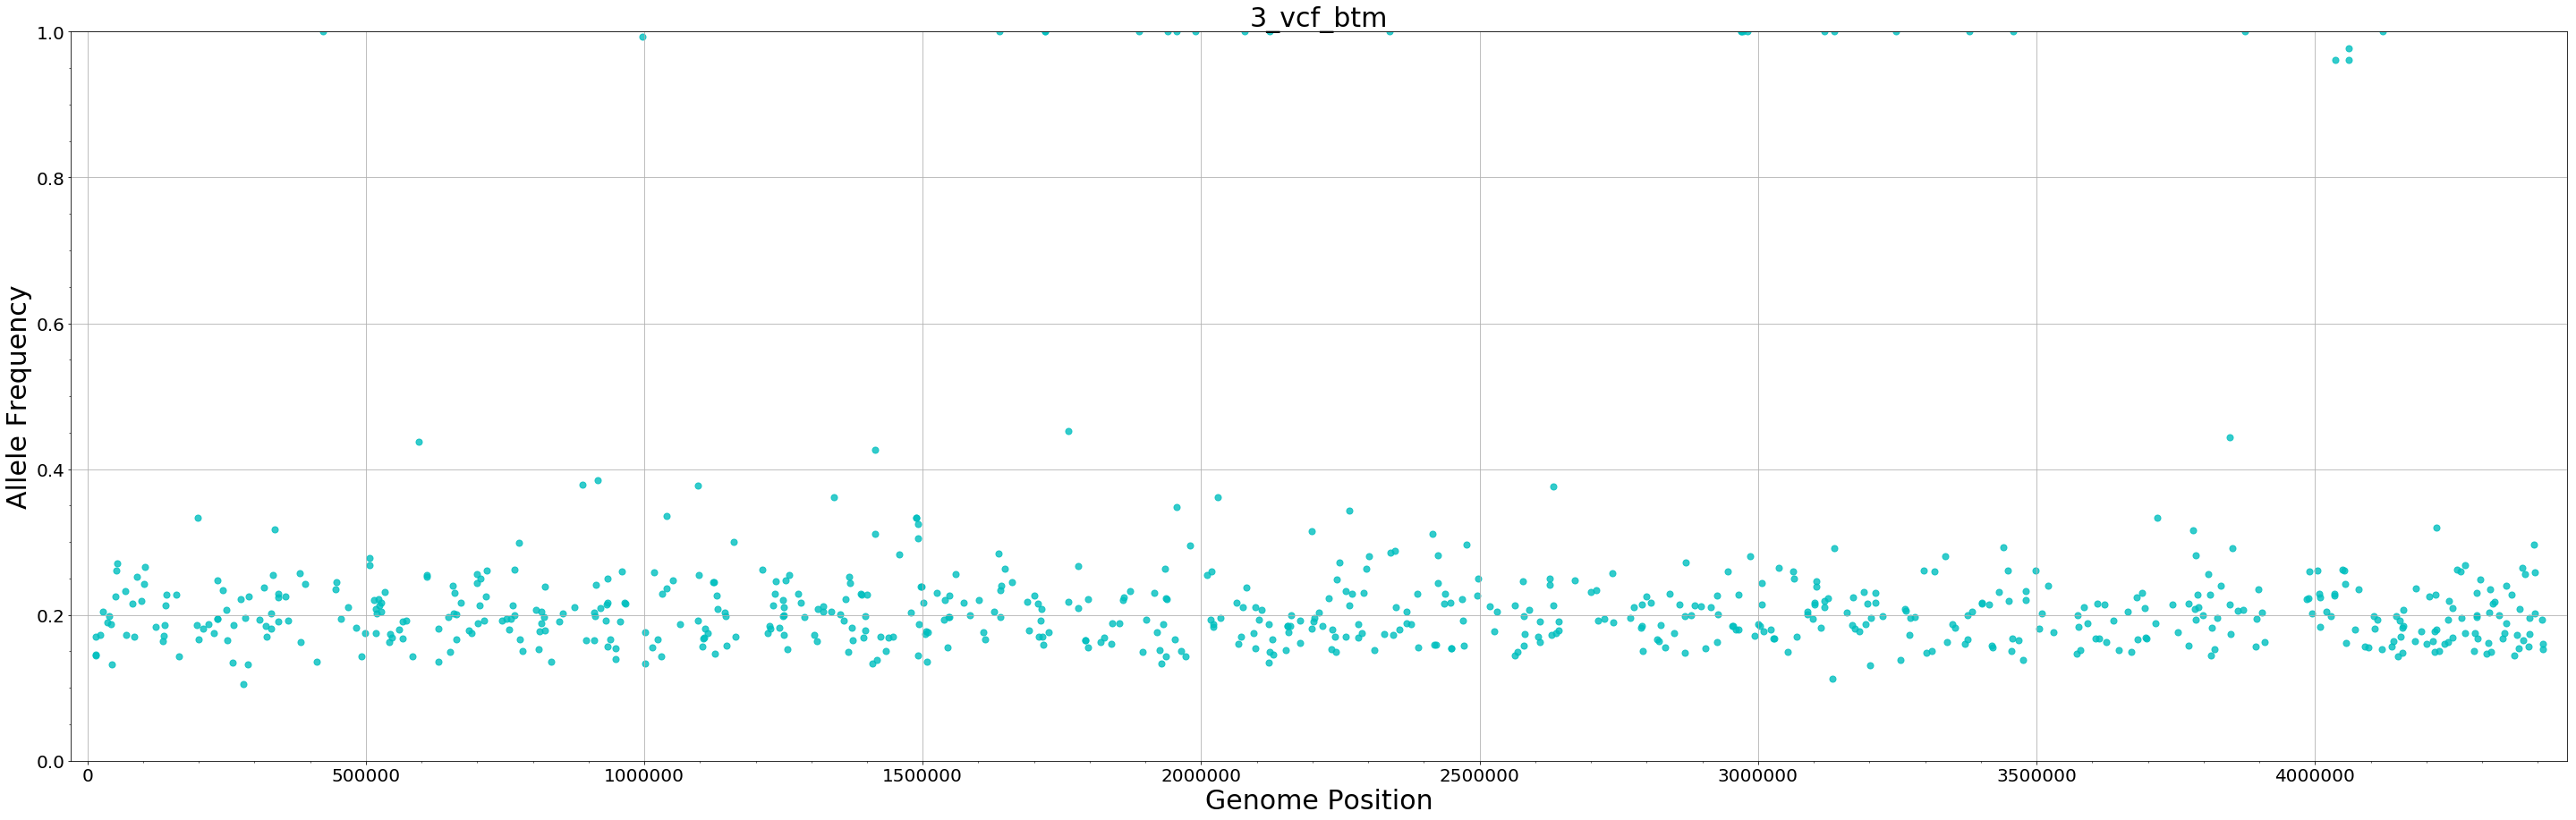

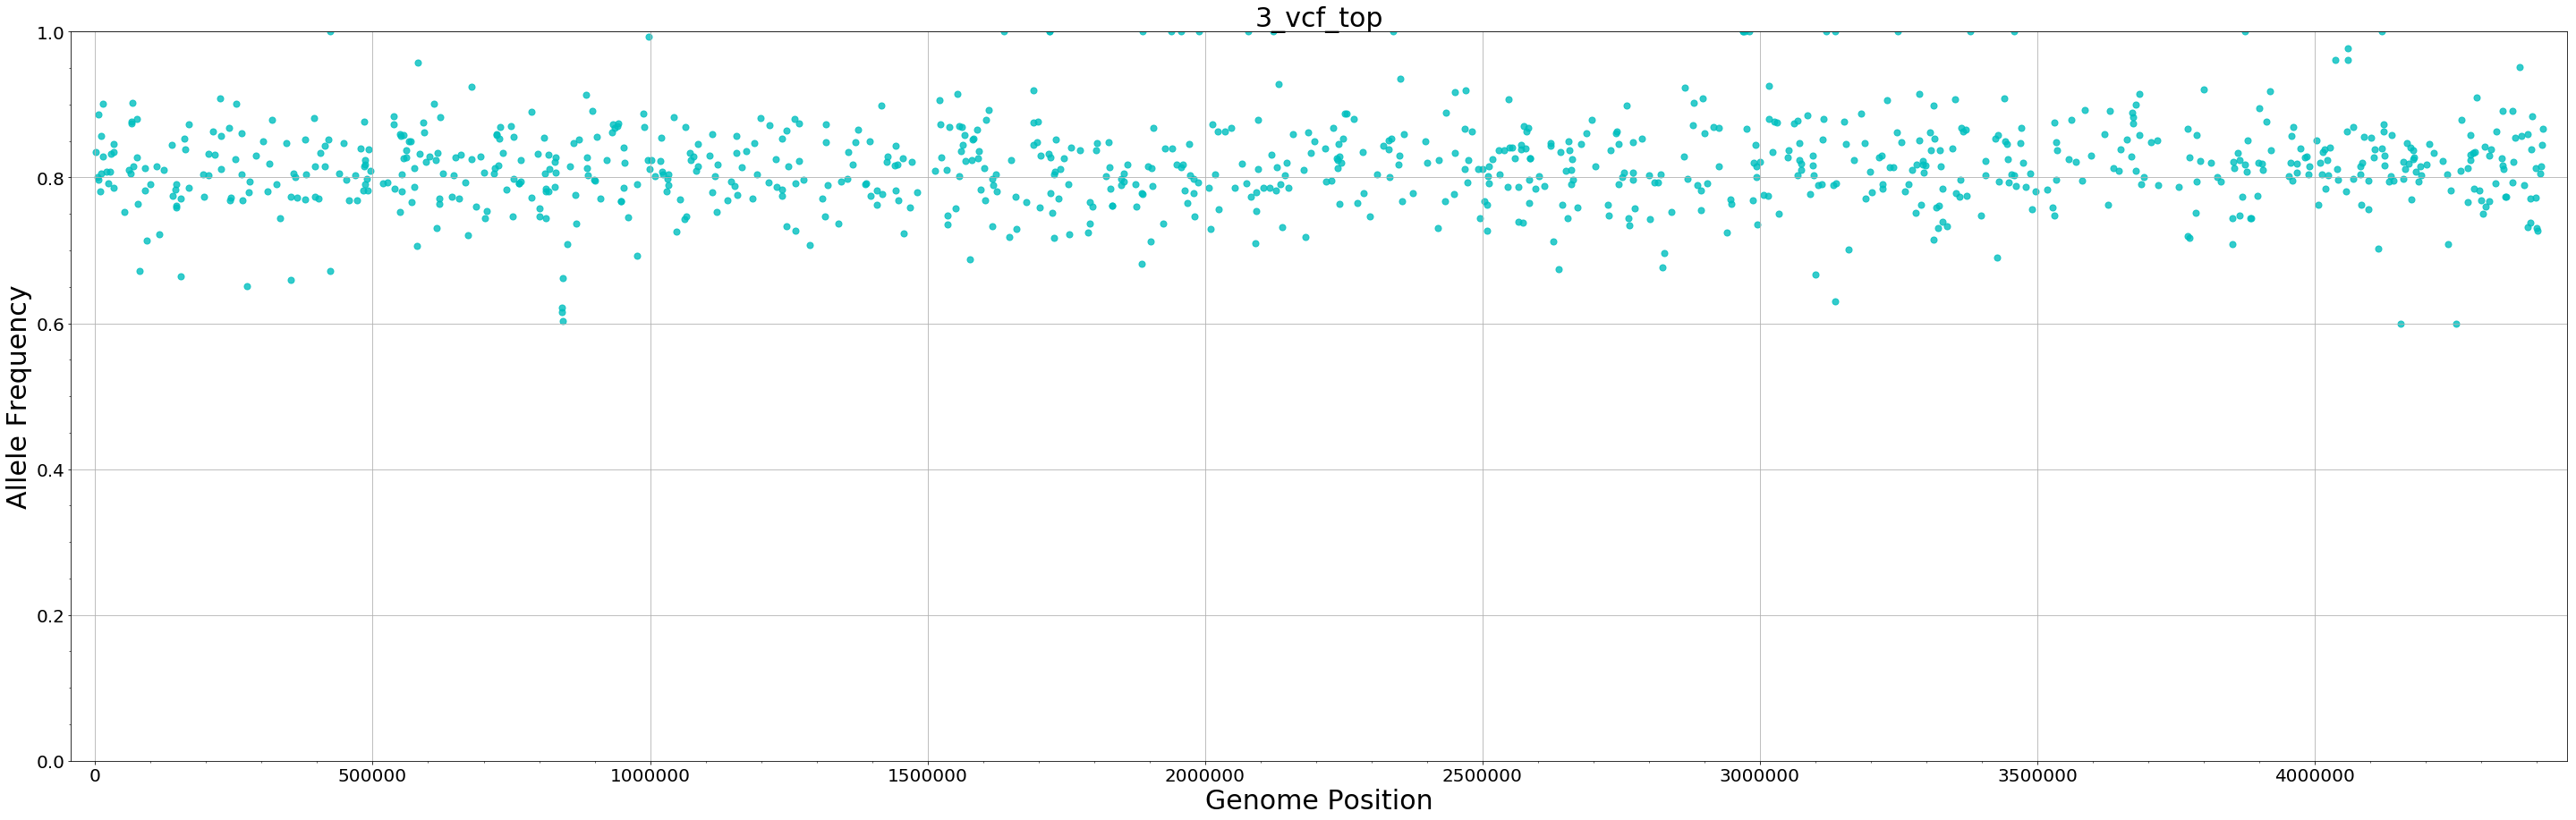

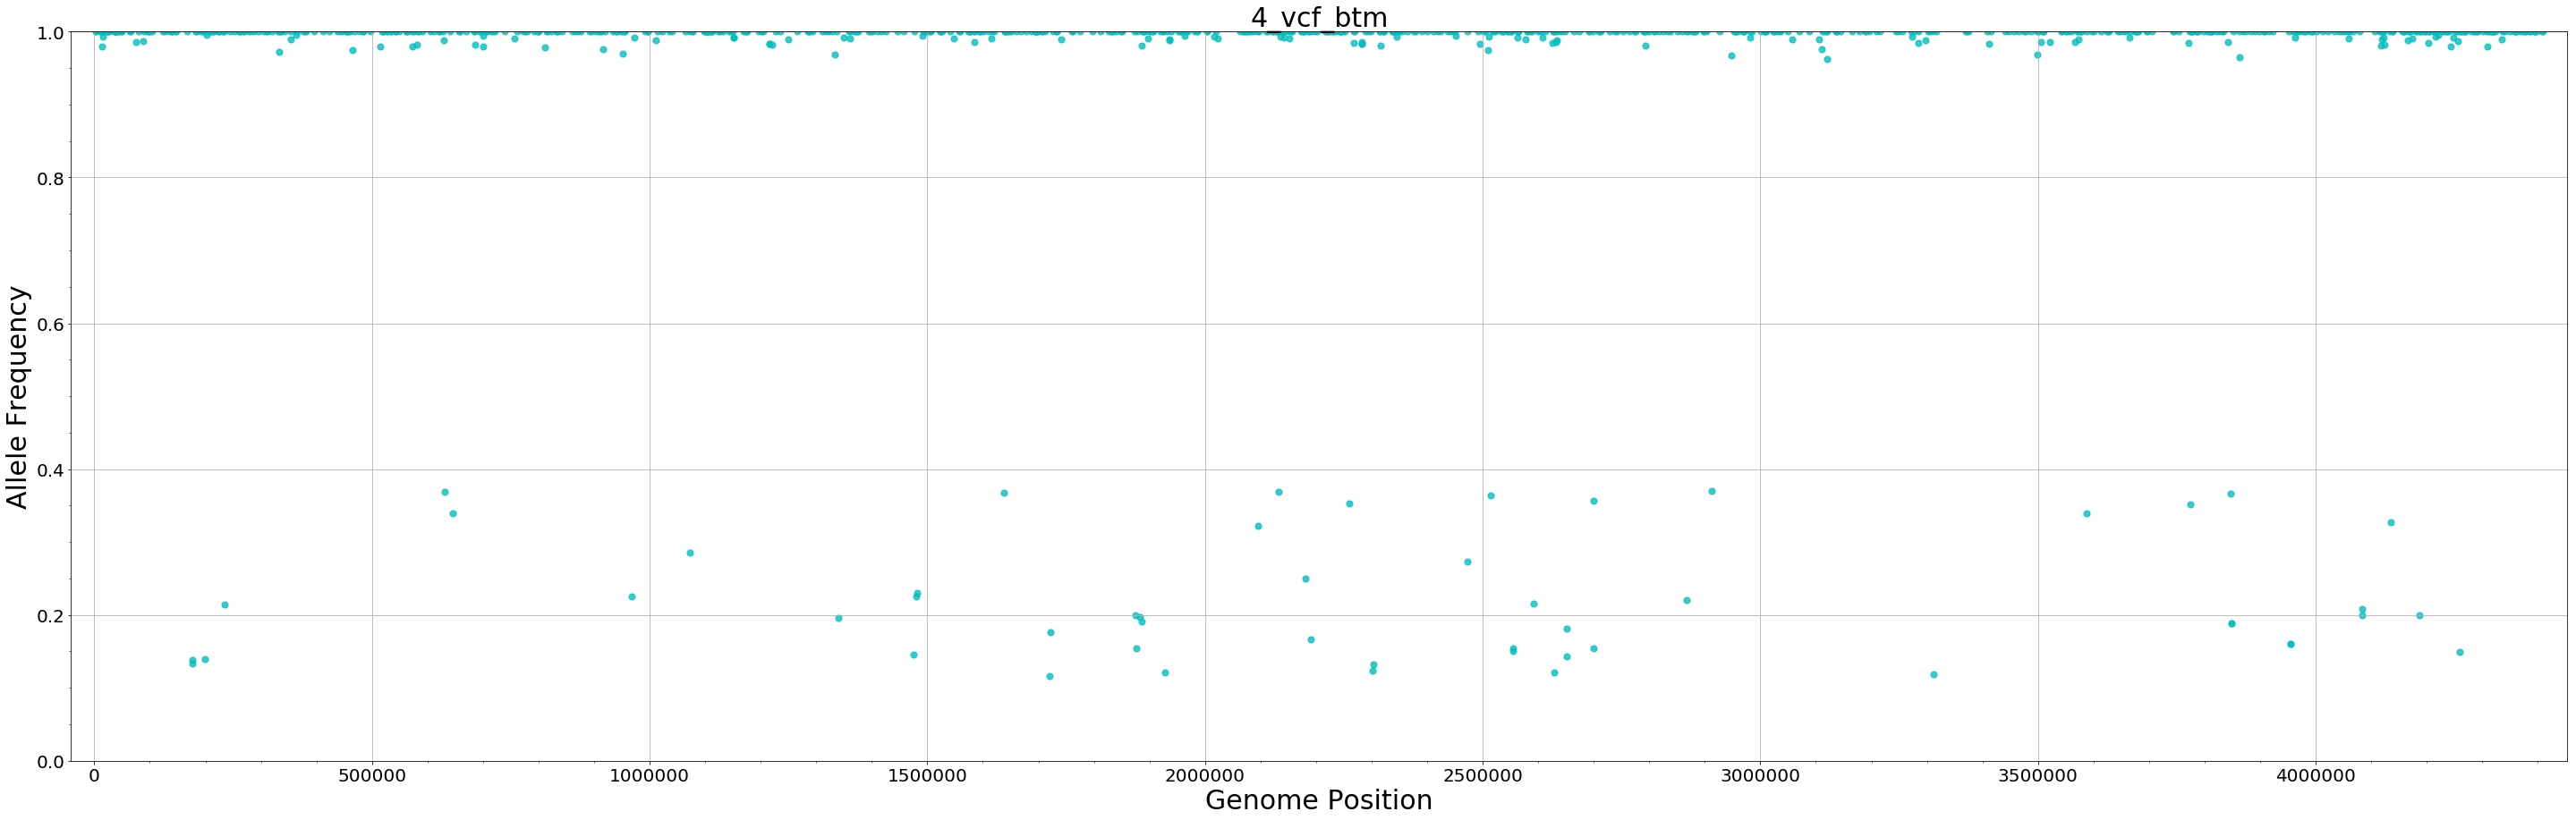

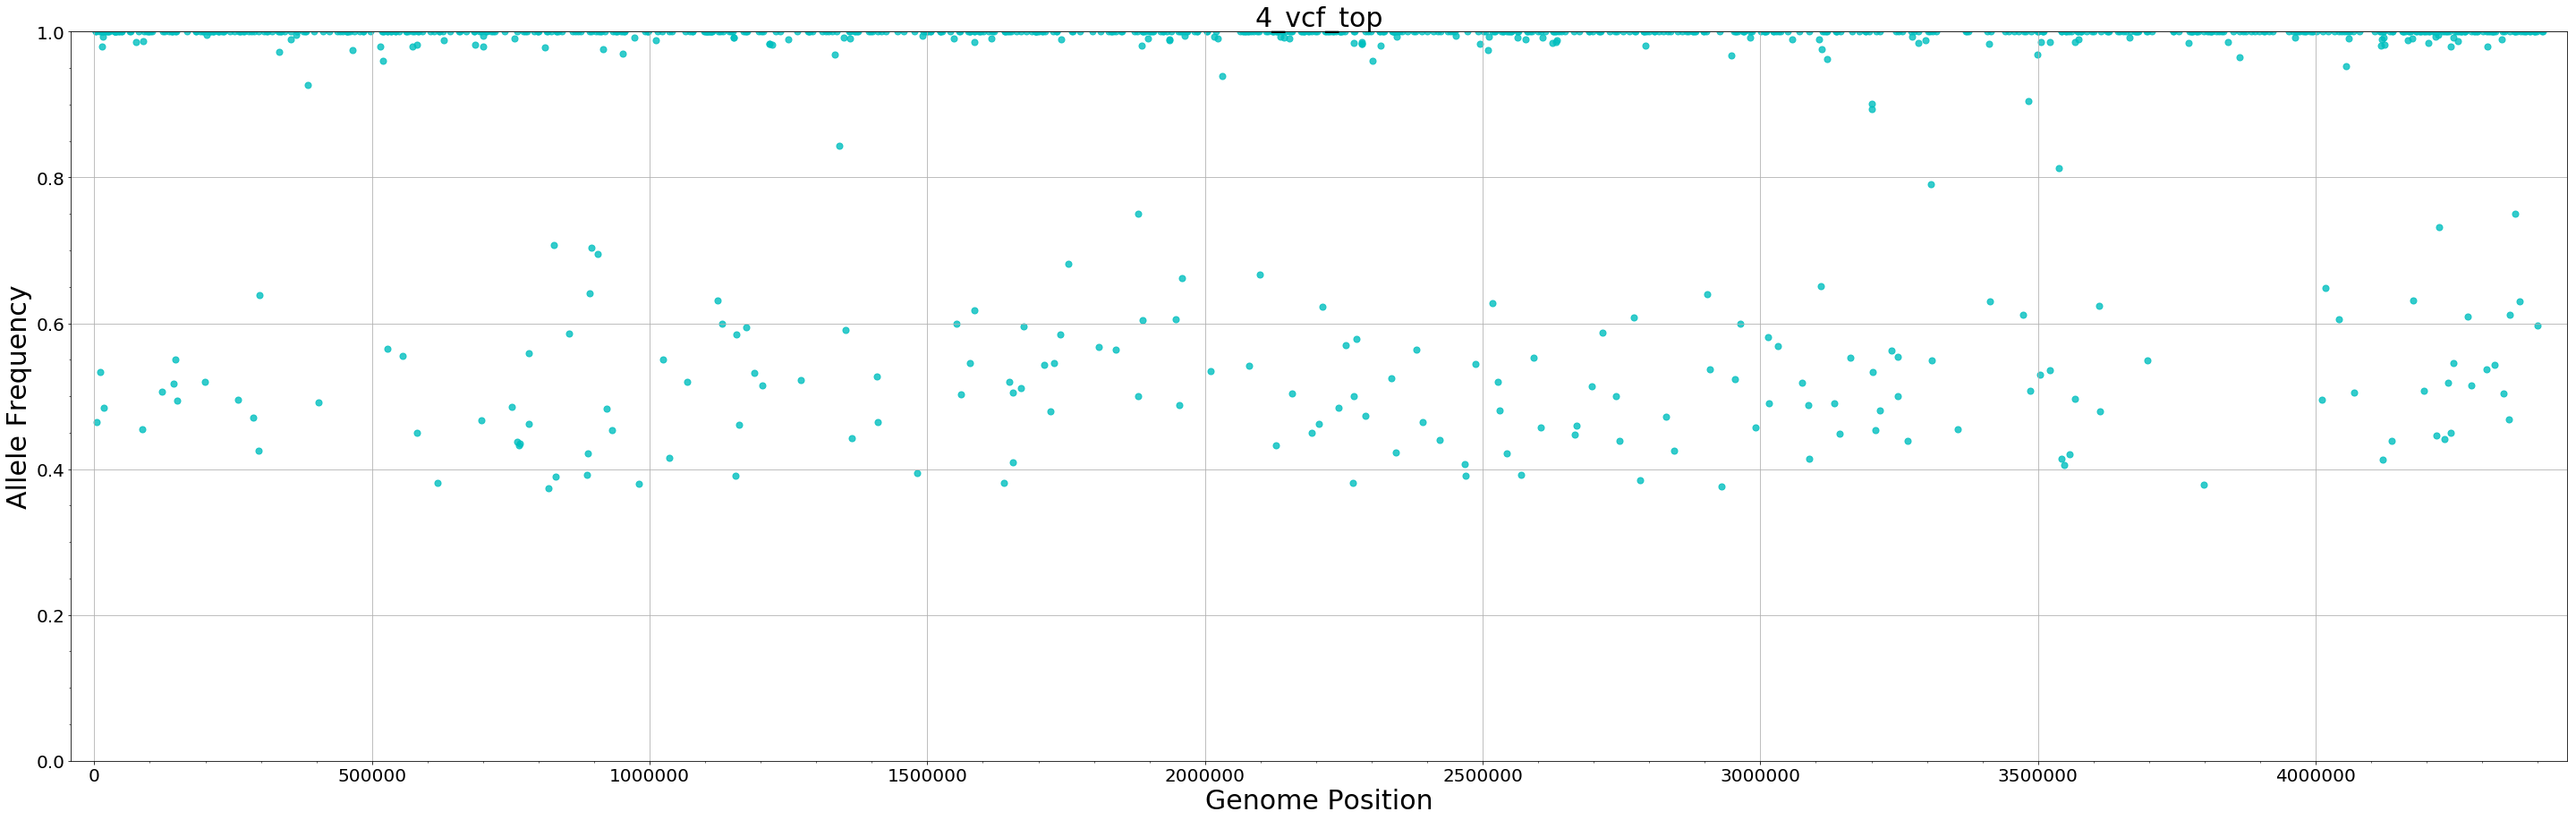

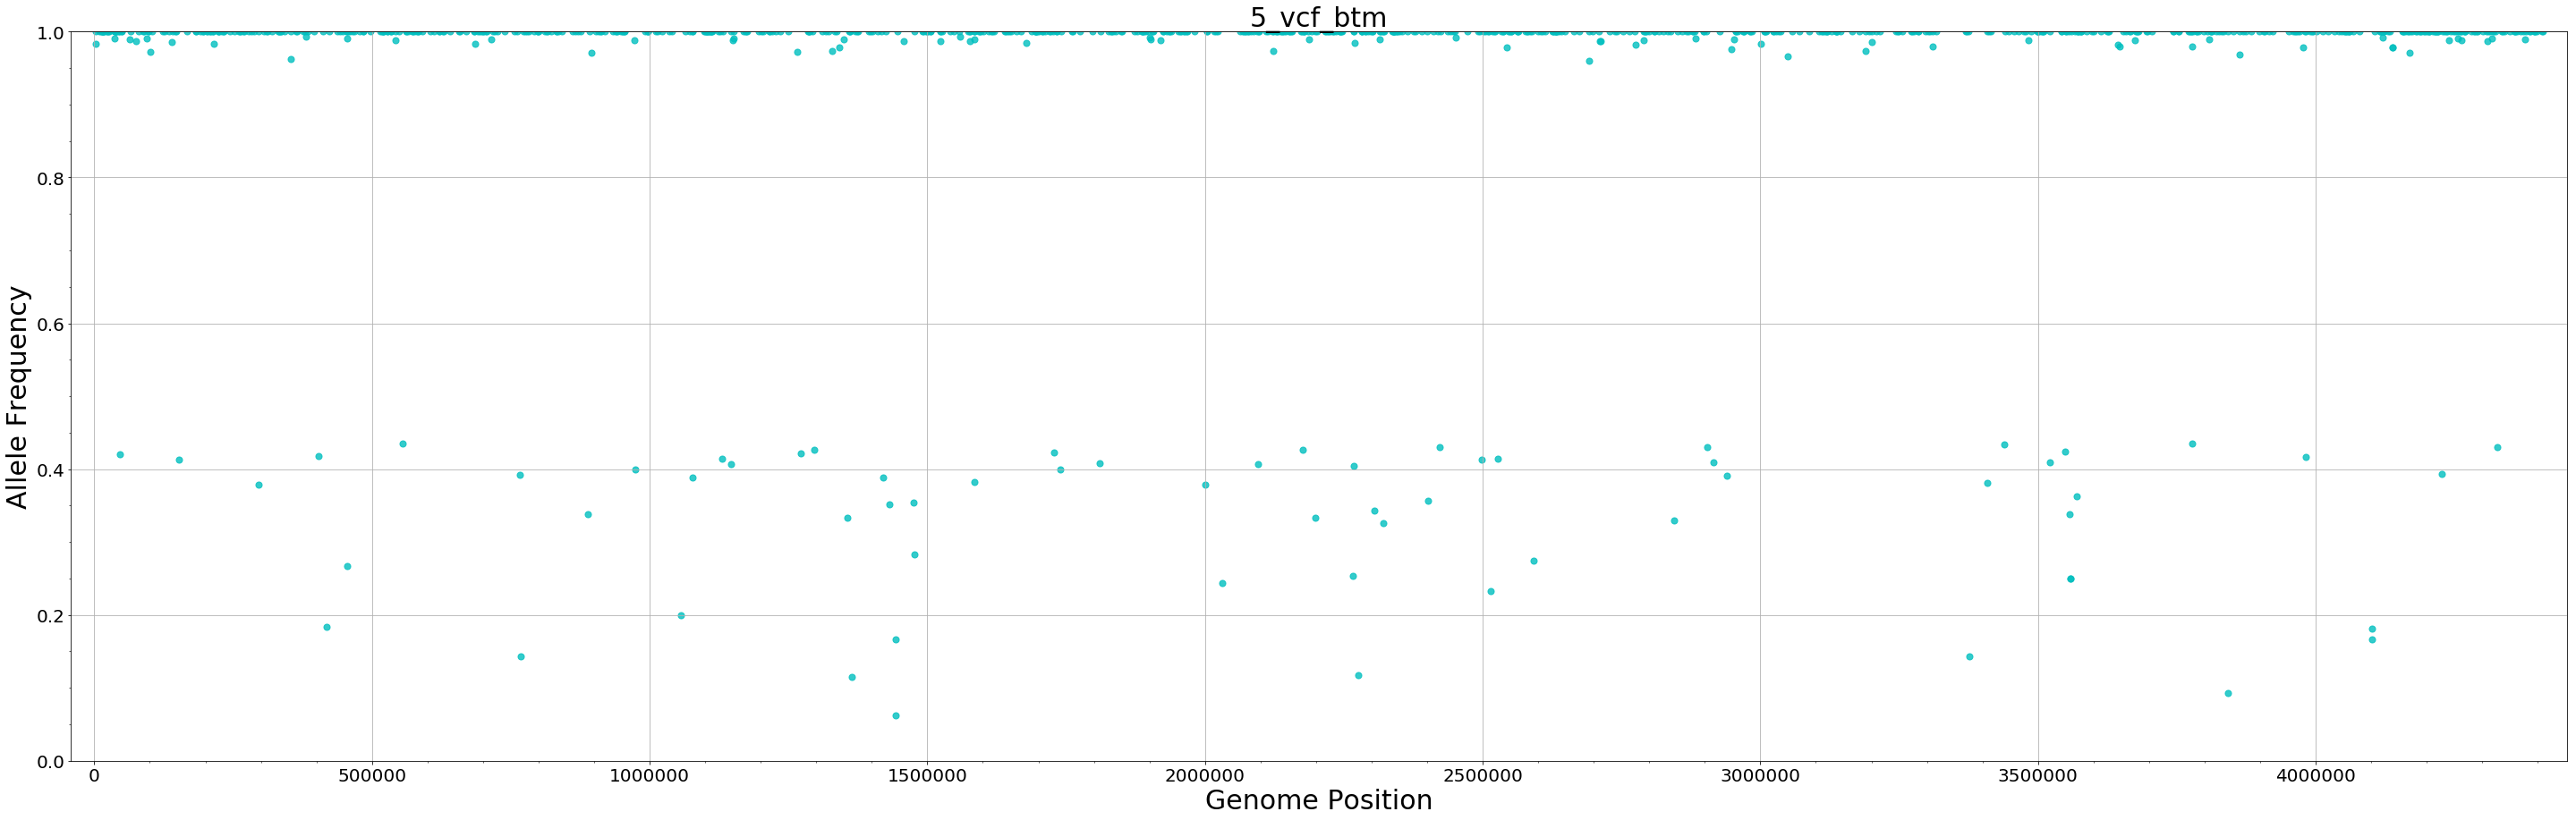

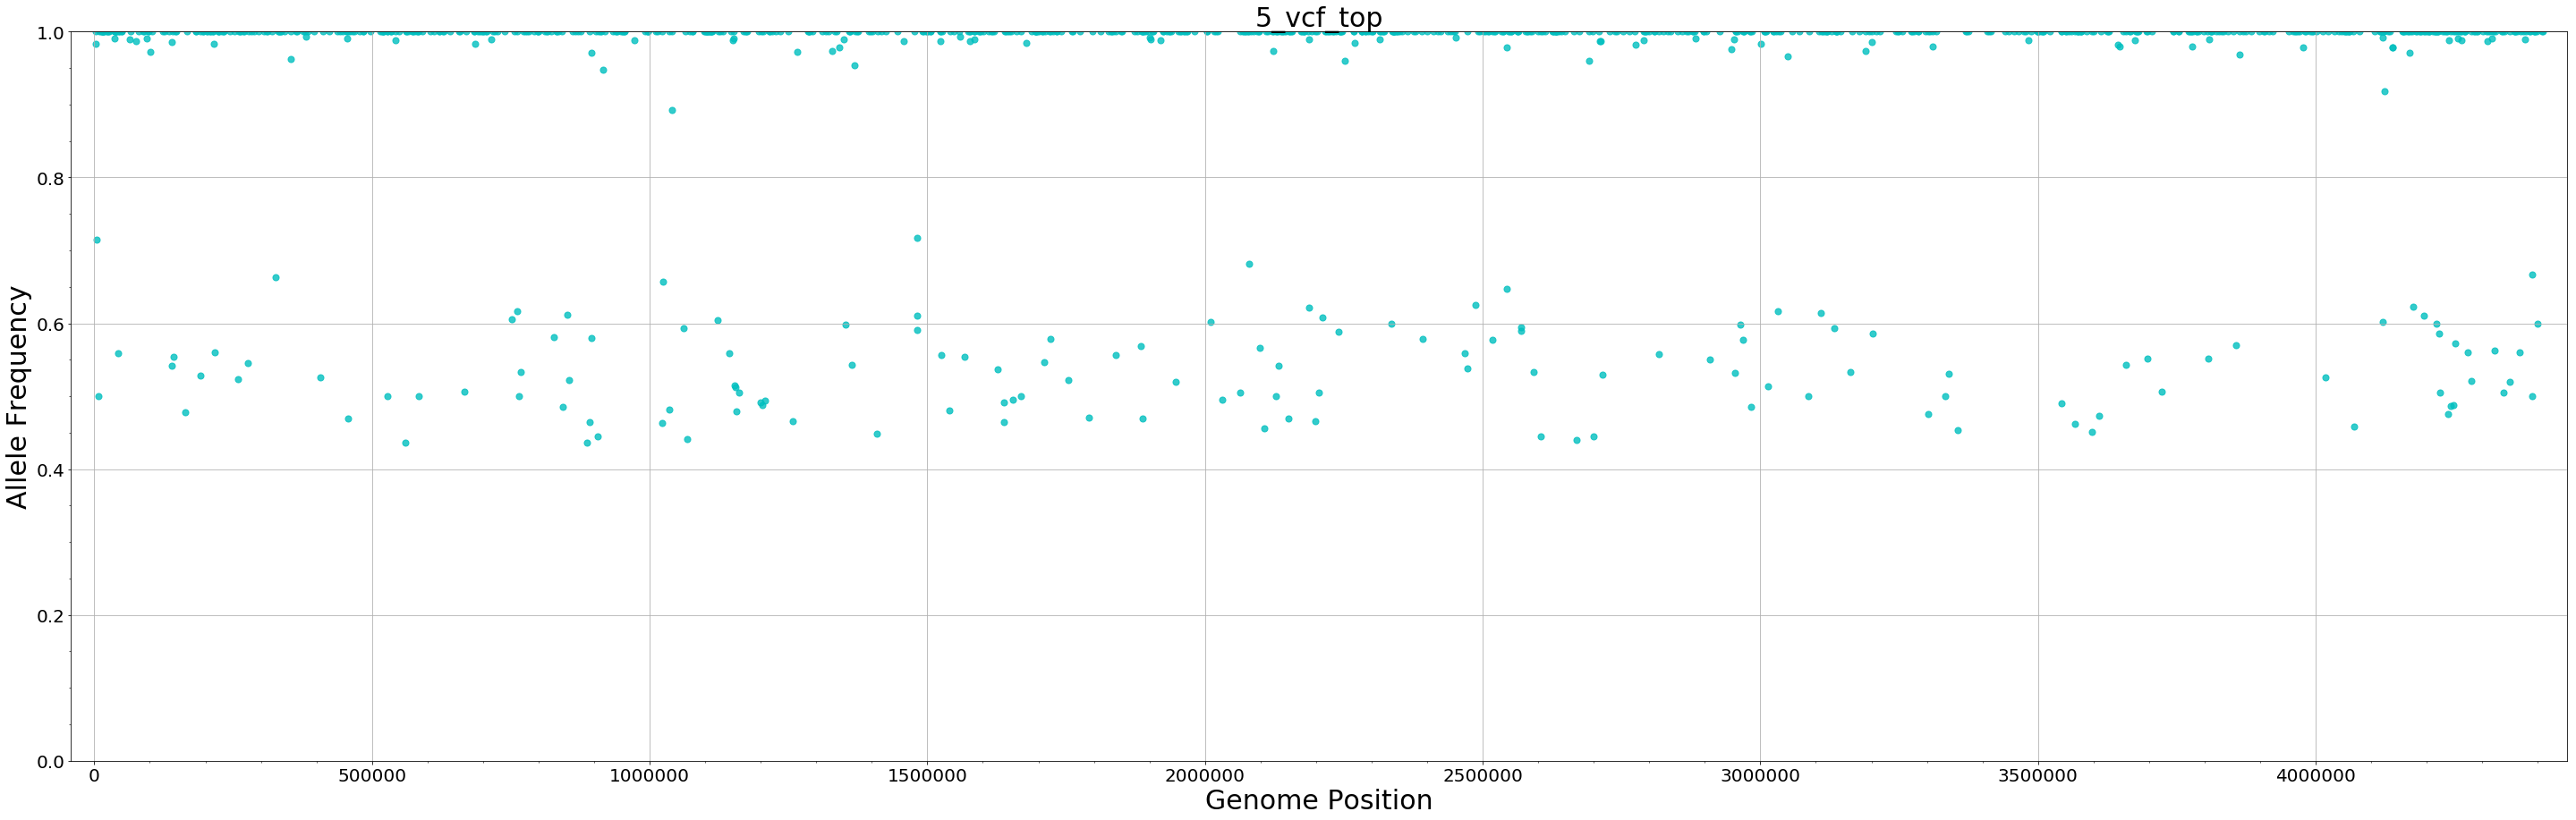

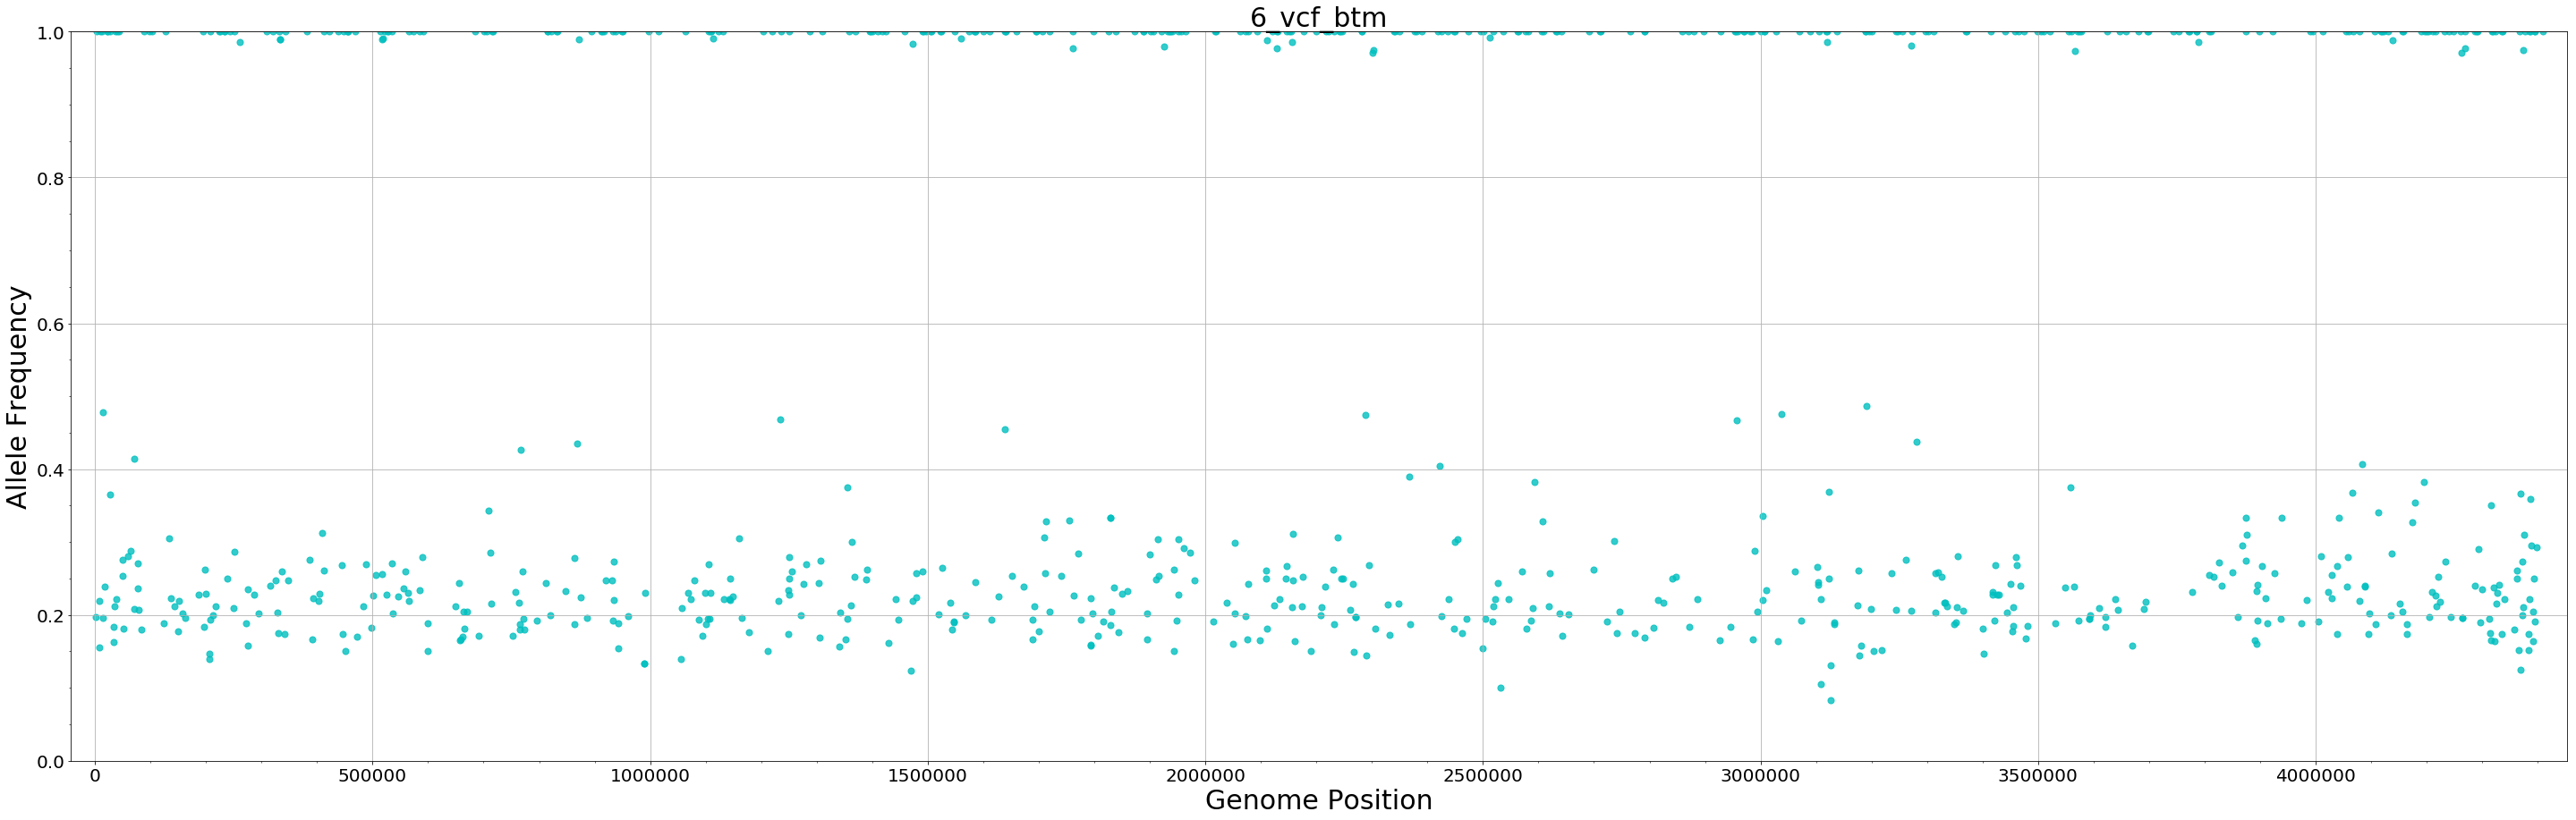

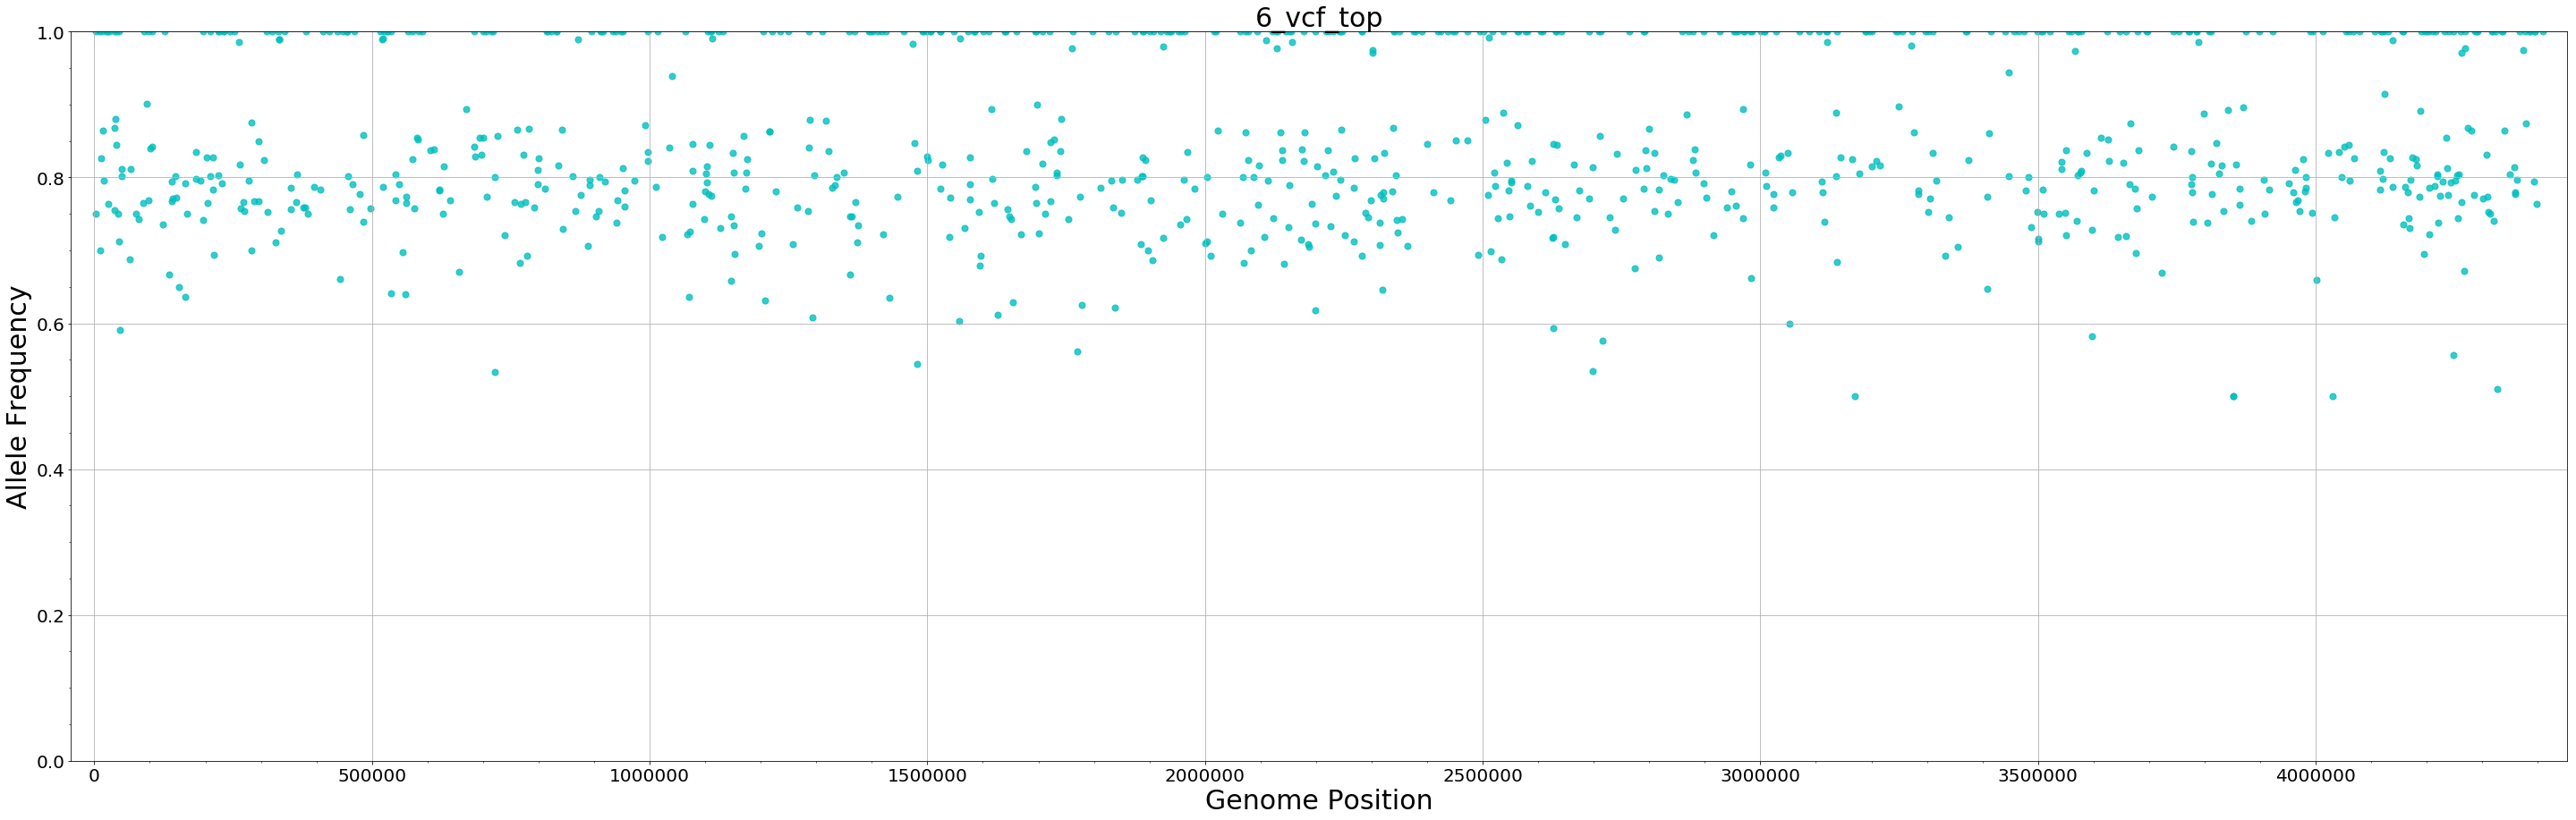

In [14]:
for name_df, df in dict_vcf.items():
    
    scatter_vcf_pos_vcf_test(df, name_df)